# Capstone Project - Product Classification Using Machine Learning

This project uses product data from an e-commerce company named The Otto Group to attempt to classify each of their products into 9 different categories. The idea for the project came from a [Kaggle](https://www.kaggle.com/c/otto-group-product-classification-challenge) competition.

### Load Data

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('train.csv')

# Dropping the id column and storing target separately
target = data['target'].str.slice(-1)
features = data.drop(['target','id'], axis=1)

print('Features shape: ', features.shape)
features.head()

Features shape:  (61878, 93)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,6,1,5,0,0,1,...,22,0,1,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


### Analyze Data

In [37]:
# Show which features have the highest and lowest mean counts as well as the overall max value.
print('Highest mean feature: ', features.mean().idxmax(), features.mean().max())
print('Lowest mean feature: ', features.mean().idxmin(), features.mean().min())
print('Overall max value: ', features.max().idxmax(), features.max().max())

Highest mean feature:  feat_67 2.89765344711
Lowest mean feature:  feat_6 0.0256957238437
Overall max value:  feat_73 352


The below snippet uses PCA to perform feature reduction to 5 components and then see which of the features contribute the most to the variance to have some knowledge of the most important features. The basis for this code was taken from the customer segement project https://github.com/udacity/machine-learning/blob/master/projects/customer_segments/visuals.py.

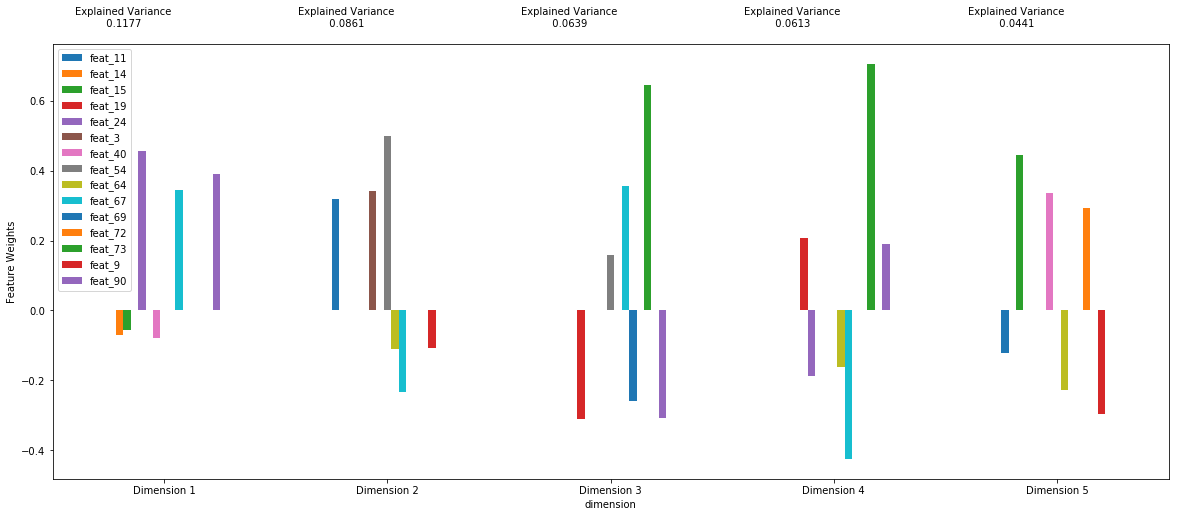

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline 

def pca_results(good_data, pca):

    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions
    
    def get_top_bottom_features(comp, dim):
        c = pd.concat([comp.loc[dim].nlargest(3), comp.loc[dim].nsmallest(3)])
        c = c.to_frame('value').reset_index().rename(columns={'index': 'feature'}).assign(dimension=dim)
        c = c.pivot(index='dimension', columns='feature', values='value')
        return c
    
    important_components = [get_top_bottom_features(components, d) for d in dimensions]
    important_components = pd.concat(important_components)
    
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (20,8))

    # Plot the feature weights as a function of the components
    important_components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca = PCA(n_components=5)
pca.fit(features)

pca_results = pca_results(features, pca)

### Preprocess Data

In [3]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 13)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 49502 samples.
Testing set has 12376 samples.


### XGBoost
The classifer will first be run with the default parameters then using GridSearch a few parameters will be refined to arrive at an optimized model.

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.model_selection import GridSearchCV

In [22]:
# Build model and fit
xgboost_model = XGBClassifier(random_state=13)
xgboost_model.fit(X_train, y_train)

# Predict model and calculate accurracy
y_pred = xgboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100.0))

# Predict model probabilities for each class and calculate log loss
y_pred_prob = xgboost_model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_prob)
print("Log Loss: {:.4f}".format(loss))

Accuracy: 77.34%
Log Loss: 0.6477


In [7]:
# Now attempt to refine the model using GridSearch to find the best model
xgboost_model = XGBClassifier(random_state=13)

# Parameters to attempt
parameters = {'n_estimators': [50, 200, 500], 'max_depth': [2, 5, 10], 'learning_rate': [0.01, 0.001, 0.2]}

scorer = make_scorer(log_loss, greater_is_better = False, needs_proba = True)

grid = GridSearchCV(xgboost_model, parameters, scorer)
grid_fit = grid.fit(X_train, y_train)

best_xgboost = grid_fit.best_estimator_

# Predict model and calculate accurracy
y_pred = best_xgboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100.0))

# Predict model probabilities for each class and calculate log loss
y_pred_prob = best_xgboost.predict_proba(X_test)
loss = log_loss(y_test, y_pred_prob)
print("Log Loss: {:.4f}".format(loss))

KeyboardInterrupt: 

In [18]:
print(y_pred[0:50])

['1' '8' '6' '6' '2' '1' '7' '8' '2' '8' '2' '2' '8' '3' '2' '2' '8' '8'
 '8' '6' '8' '1' '8' '3' '9' '6' '2' '6' '2' '8' '6' '2' '3' '3' '8' '1'
 '6' '2' '2' '2' '6' '2' '6' '6' '6' '6' '9' '6' '8' '2']
